# 네이버 영화리뷰 감성분석 도전하기

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os

---

# 1. 데이터 준비와 확인

In [2]:
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print(test_data.shape)
test_data.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 2. 데이터 구성

1. docoment 컬럼 기준으로 데이터 중복 제거
2. NaN 하나라도 컬럼에 있으면 결측치 제거
3. Mecab으로 형태소 추출 -> 토큰화
4. 안쓰는 불용어(stopwords)는 빼기
5. 토큰들(단어) 각각 개수를 세봤을 때, 많은 것 순으로 정렬한 뒤 {10000-4}개 단어들만 가져와서
    - 별도 `'<PAD>', '<BOS>', '<UNK>', '<UNUSED>'` 추가
6. 단어 딕셔너리 만들기; word_to_index, index_to_word

In [127]:
import re

def preprocess_sentence(sentence):
#     sentence = re.sub(r"[a-zA-Z!@#$%^&*()~!?\'\".,]+", " ", sentence)
    sentence = re.sub(r"[^ 가-힣]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence


print(preprocess_sentence("This is sample sentence. \"안녕하세요~~~~~\" 주인공이 말했다"))

안녕하세요 주인공이 말했다
True
False


In [165]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        s = preprocess_sentence(sentence)
        temp_X = tokenizer.morphs(s) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        s = preprocess_sentence(sentence)
        temp_X = tokenizer.morphs(s) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4) # 많은 것 순으로 정렬한 뒤, {num_words-4}개 단어들만 반환
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def get_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(get_indexlist, X_train)) #
    X_test = list(map(get_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [166]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

46885


In [167]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [168]:
len(X_train)

146182

### 데이터 확인

In [169]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

---

# 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 데이터셋 내 문장 길이 분포

In [171]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.551139301419584
문장길이 최대 :  83
문장길이 표준편차 :  11.439028396810833


In [172]:
import matplotlib.pyplot as plt

### 적절한 최대 문장 길이 지정

In [201]:
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  42
전체 문장의 0.9551702425014974%가 maxlen 설정값 이내에 포함됩니다. 


### 패딩 추가

In [202]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 42)
(49157, 42)


---

# 4. 모델 구성 및 validation set 구성

In [203]:
VOCAB_SIZE = 10000
WORD_VECTOR_DIM = 10

### RNN 모델 구성

In [241]:
def getRNN_model(vocab_size, word_vector_dim, embedding_layer=False):
    if not embedding_layer:
        embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    model.add(tf.keras.layers.LSTM(8))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.summary()
    
    return model

### 1-D CNN

In [242]:
def getCNN_model(vocab_size, word_vector_dim, embedding_layer=False):
    if not embedding_layer:
        embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(5))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.summary()
    
    return model

### GlobalMaxPooling1D

In [243]:
def getGlobalMaxPooling_model(vocab_size, word_vector_dim, embedding_layer=False):
    if not embedding_layer:
        embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))

    model = tf.keras.Sequential()
    model.add(embedding_layer)
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.summary()
    
    return model

### Validation set 구성

In [207]:
val_size = len(X_test) # 테스트셋 사이즈와 동일하게 validation set 구성

X_val = X_train[:val_size]
y_val = y_train[:val_size]

partial_X_train = X_train[val_size:]
partial_y_train = y_train[val_size:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(97025, 42)
(97025,)


---

# 5. 모델 훈련 개시

### RNN model 훈련

In [208]:
RNN_model = getRNN_model(VOCAB_SIZE, WORD_VECTOR_DIM)

RNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

RNN_history = RNN_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 100,689
Trainable params: 100,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
190/190 [==============================] - 3s 9ms/step - loss: 0.5934 - accuracy: 0.7257 - val_loss: 0.4584 - val_accuracy: 0.8207
Epoch 2/20
190/190 [==============================] - 1s 6ms/step - loss: 0.3975 - accuracy: 0.8360 - v

In [209]:
RNN_results = RNN_model.evaluate(X_test,  y_test, verbose=2)

print(RNN_results)

1537/1537 - 3s - loss: 0.4979 - accuracy: 0.8260
[0.4978763461112976, 0.8260267972946167]


### CNN model 훈련

In [210]:
# 1-D CNN model 학습
CNN_model = getCNN_model(VOCAB_SIZE, WORD_VECTOR_DIM)

CNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

CNN_history = CNN_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          1136      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

In [211]:
CNN_results = CNN_model.evaluate(X_test,  y_test, verbose=2)

print(CNN_results)

1537/1537 - 2s - loss: 0.7633 - accuracy: 0.7923
[0.7632555961608887, 0.7922778129577637]


### GlobalMaxPooling1D model 훈련

In [212]:
# GlobalMaxPooling1D model 학습
globalMaxPooling_model = getGlobalMaxPooling_model(VOCAB_SIZE, WORD_VECTOR_DIM)

globalMaxPooling_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

globalMaxPooling_history = globalMaxPooling_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 10)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 9         
Total params: 100,097
Trainable params: 100,097
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
190/190 [==============================] - 1s 4ms/step - loss: 0.6333 - accuracy: 0.7374 - val_loss: 0.5130 - val_accuracy: 0.8023
Epoch 2/20
190/190 [==============================] - 1s 4ms/step - loss: 0.4305 - accuracy: 0.8220 - v

In [213]:
globalMaxPooling_results = globalMaxPooling_model.evaluate(X_test,  y_test, verbose=2)

print(globalMaxPooling_results)

1537/1537 - 2s - loss: 0.5085 - accuracy: 0.8156
[0.5084824562072754, 0.8155705332756042]


---

# 6. Loss, Accuracy 그래프 시각화

### RNN model - Loss, Accuracy 시각화

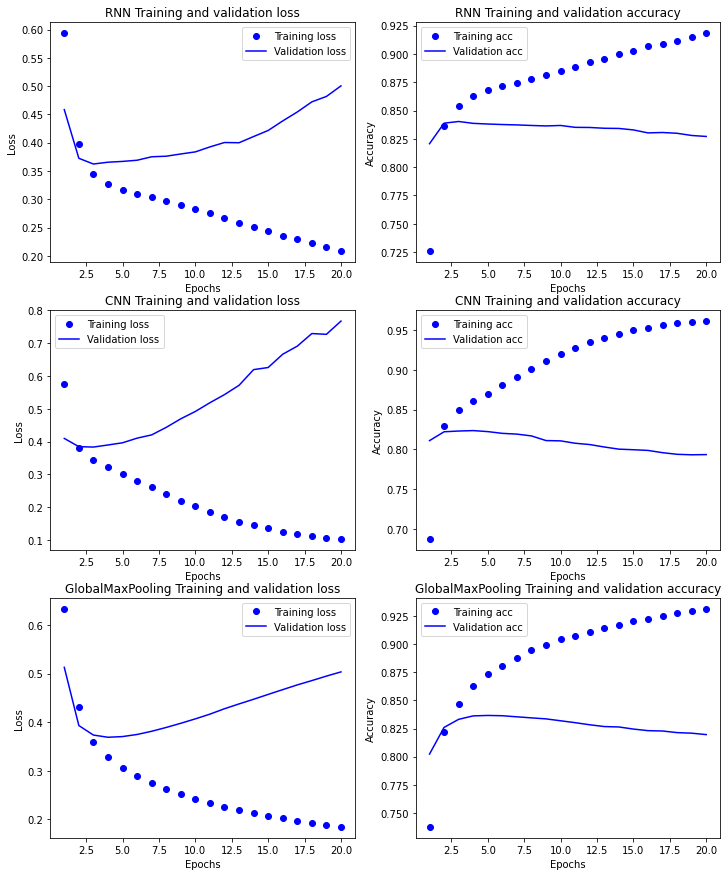

In [214]:
def visualize(name, history, plt, height, idx=1):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)


    ax1 = fig.add_subplot(height,2,idx)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')

    plt.title(name + ' Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ax2 = fig.add_subplot(height,2,idx+1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(name + ' Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    
histories = {'RNN': RNN_history, 'CNN': CNN_history, 'GlobalMaxPooling': globalMaxPooling_history}

fig = plt.figure(figsize=(12,15))
idx = 0
for name, h in histories.items():
    visualize(name, h, plt, 3, (idx*2)+1)
    idx += 1
plt.show()

---

# 7. 학습된 Embedding 레이어 분석

In [215]:
embedding_layer = globalMaxPooling_model.layers[0]
weights = embedding_layer.get_weights()[0]
# print(weights.shape)

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(VOCAB_SIZE-4, WORD_VECTOR_DIM))

vectors = globalMaxPooling_model.get_weights()[0]
for i in range(4,VOCAB_SIZE):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [216]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사람']
vector

array([-0.01397574, -0.04528309, -0.13647899, -0.14192891, -0.14126888,
       -0.13324222,  0.06186666, -0.0007721 , -0.14897779, -0.21387856],
      dtype=float32)

In [217]:
word_vectors.similar_by_word("사람") # "사랑" 단어와 가장 유사한 단어들을 출력

[('결정판', 0.9504469037055969),
 ('대표', 0.9466128349304199),
 ('놓', 0.9418346881866455),
 ('빠진', 0.9361637830734253),
 ('을까', 0.933508574962616),
 ('상식', 0.93063884973526),
 ('블루', 0.912011981010437),
 ('라면', 0.9033735990524292),
 ('특이', 0.9022936820983887),
 ('침', 0.89844810962677)]

그나마 가장 나은 성능을 가진 모델의 워드벡터로 유사도를 분석해봤으나, 좋은 결과를 내지 않았습니다.

---

# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [235]:
import gensim
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

word2vec_path = '/aiffel/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사람']
vector

array([ 0.7412252 , -1.1187236 ,  2.0681474 ,  1.05749   , -1.3211275 ,
       -2.414994  , -1.133681  ,  1.5452526 , -0.4543698 ,  0.02380616,
        0.12370981, -0.8839078 , -2.9051683 , -0.34940982,  1.3418512 ,
        2.8225965 ,  1.0794274 ,  0.4287113 , -1.9613483 ,  0.4262147 ,
       -0.40650806, -0.34994036, -0.8416261 ,  0.52574843, -0.29543158,
       -0.5593075 ,  0.84687376,  0.0889315 , -2.5240638 ,  0.46828857,
        2.8982353 , -1.6508341 , -0.37446976, -2.2825975 ,  0.7083552 ,
       -0.59711653,  0.2839199 , -1.0247895 ,  2.3036754 ,  0.45918384,
       -0.83396995,  0.85293204,  0.972802  , -0.5457918 , -0.93798906,
       -0.8009529 ,  2.160266  ,  0.10052549, -0.16650781, -0.07592812,
       -0.45869842,  1.3352628 ,  2.3284414 ,  0.7132327 , -2.4690466 ,
        0.05213251,  0.38745207, -0.2773064 , -0.67375   , -0.59059584,
        1.0310122 ,  1.9923794 , -0.94680166, -1.3167765 , -1.4717319 ,
        0.97447944,  0.8103551 ,  0.8915873 ,  0.7474684 , -0.00

In [236]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("사람")

[('젊은이', 0.6494427919387817),
 ('여인', 0.6287257671356201),
 ('백성', 0.6063710451126099),
 ('포졸', 0.6043275594711304),
 ('죄인', 0.5960500836372375),
 ('선비', 0.5868039131164551),
 ('부녀자', 0.5654411315917969),
 ('죄수', 0.5639811754226685),
 ('구경꾼', 0.5620019435882568),
 ('손님', 0.5589558482170105)]

### 한국어 Word2Vec으로 임베딩 레이어 교체하기

In [237]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### 모델 다시 작성 & 학습 & 평가

In [254]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200
embedding_layer = tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True)


# getRNN_model(vocab_size, word_vector_dim, embedding_layer)
# getCNN_model(vocab_size, word_vector_dim, embedding_layer)
model = getGlobalMaxPooling_model(vocab_size, word_vector_dim, embedding_layer)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 42, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 200)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [255]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
190/190 [==============================] - 2s 6ms/step - loss: 0.7095 - accuracy: 0.4993 - val_loss: 0.6927 - val_accuracy: 0.5012
Epoch 2/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.5134 - val_loss: 0.6834 - val_accuracy: 0.5623
Epoch 3/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6505 - accuracy: 0.6306 - val_loss: 0.5919 - val_accuracy: 0.6896
Epoch 4/20
190/190 [==============================] - 1s 5ms/step - loss: 0.5376 - accuracy: 0.7336 - val_loss: 0.5045 - val_accuracy: 0.7566
Epoch 5/20
190/190 [==============================] - 1s 5ms/step - loss: 0.4778 - accuracy: 0.7736 - val_loss: 0.4705 - val_accuracy: 0.7770
Epoch 6/20
190/190 [==============================] - 1s 5ms/step - loss: 0.4432 - accuracy: 0.7953 - val_loss: 0.4498 - val_accuracy: 0.7882
Epoch 7/20
190/190 [==============================] - 1s 5ms/step - loss: 0.4160 - accuracy: 0.8110 - val_loss: 0.4367 - val_accuracy: 0.7955
Epoch 

In [256]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4303 - accuracy: 0.8165
[0.43031150102615356, 0.8165266513824463]


### 시각화

<Figure size 432x288 with 0 Axes>

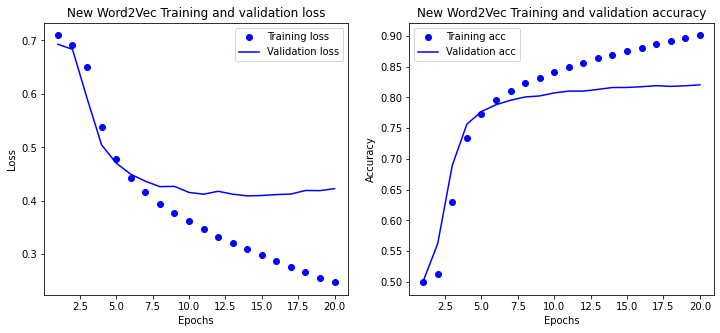

In [257]:
plt.clf()   # 그림을 초기화합니다
fig = plt.figure(figsize=(12,5))

visualize('New Word2Vec', history, plt, 1)
plt.show()

--- 

# Accuracy, loss 

1. global
```
    # 1. 첫 시도
    1537/1537 - 2s - loss: 0.4470 - accuracy: 0.8163
    [0.4470440745353699, 0.8163435459136963]
    
    # 2. 문장길이 키우기
    1537/1537 - 2s - loss: 0.4235 - accuracy: 0.8212
    [0.4234999418258667, 0.8212462067604065]
    
    # 3. 한글만 filter, 문장 길이 키우기
    1537/1537 - 2s - loss: 0.4450 - accuracy: 0.8122
    [0.4450375437736511, 0.8121732473373413]
```

2. RNN
```
    # 4. 다른 모델로 적용해보기
    1537/1537 - 3s - loss: 0.8146 - accuracy: 0.8216
    [0.8145668506622314, 0.8216123580932617]
```

# 회고

### 1. 어려웠던 점
- 데이터 전처리를 해도, 사전 크기를 늘려봐도, 문장 최대 길이를 늘려봐도... 정확도,손실에 큰 개선을 이뤄내지 못해 어려웠습니다.


### 2. 시도한 것들
#### 1) word_vector_dimension 사이즈를 어떤걸로 설정해야할까?
    - 처음에는 적정 사이즈를 어떻게 두면 좋을지 검색해보고, number_of_categories**0.25 이렇게 초기 설정해서 진행했습니다.
        - https://stackoverflow.com/questions/48479915/what-is-the-preferred-ratio-between-the-vocabulary-size-and-embedding-dimension
    - 이후에는 accuracy가 잘 나오는 값을 찾아서 값을 늘려 학습해보았습니다.
#### 2) validation dataset 개수는 얼마가 적절할까?
    - test dataset size는 0.2가 적절하다는걸 아는데, validation dataset size는 어떻게 구성하는게 좋을지 찾아봤습니다.
        - https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio
    - validation dataset도 0.2가 적절하다고 합니다. (작은 데이터셋인 경우에는 7:3 또는 6:4도 권장)
    - 그러나 현재 train, test dataset은 이미 나눠진 상태였기 때문에, validation size를 test size와 동일하게 구성하였습니다.
#### 3) 한글 임베딩 파일을 로드할 때 에러 발생발생했고, 아래 링크에서 문제해결을 찾아 에러를 고쳤습니다.
    - https://stackoverflow.com/questions/27659985/error-utf8-codec-cant-decode-byte-0x80-in-position-0-invalid-start-byte
#### 4) 데이터 전처리 추가
    - 영어, 숫자, 특수문자는 한글 텍스트 분석에 적절하지 않다 판단하였고, 데이터 전처리를 통해 데이터에 한글만 유효하도록 수정했습니다. (자음, 모음만 있는 것도 삭제)
#### 5) 데이터 전처리를 추가하고 난 뒤, "CNN Negative dimension size caused by subtracting .."와 같은 에러가 발생했습니다.
    - 문장 최대 길이를 2 -> 2.5 가중치를 늘려 오류를 해결했습니다.
        - max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)



### 3. 루브릭 달성하지 못한 이유
```
[네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함] 루브릭을 달성하지 못했습니다. 
가장 성능이 괜찮아 보였던 GlobalMaxPooling1D 기준으로 해보기도 했고
데이터 전처리를 하거나, 사전 크기를 늘려봐도, 문장 최대 길이를 늘려봐도... 정확도,손실에 큰 개선을 이뤄내지 못했습니다. 
저도 이유를 알고싶습니다. 다른 분들의 과정도 궁금합니다
```
